# LAB: Stochastic Gradient Descent SOLUTIONS

The objective of this lab session is to implement and test:
- Stochastic gradient descent with constant stepsizes
- Stochastic gradient descent with shrinking stepsizes
- Stochastic gradient descent with sampling with/without replacement
- Stochastic gradient descent with averaging
- Stochastic gradient descent with momentum

and compare your implementation with gradient descent.

Throughout the notebook you will find commented boxes like this one



In [248]:
### TODO ###
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes. Good luck!

In [249]:
%matplotlib inline
!pip install numba

In [250]:
import numpy as np
from numpy import linalg as la
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numpy.matlib
#from numba import njit, jit, jitclass  # A just in time compiler to speed things up!

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top w, b_i) + \frac \lambda 2 \|w\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \ell(x_i^\top w, y_i) + \frac \lambda 2 \|w\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$
and
$$
\nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

Denote by $L$ the Lipschitz constant of $f$ and $X = [x_1, \ldots, x_n].$
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{4 n} + \lambda
$$
For full-gradient methods, the theoretical step-size is $1 / L$.

We now introduce a class that will be used for the solvers.

In [251]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda

    def grad(self, w):
        ### TODO ###
        gradd = (1/self.n) * np.dot(self.X.T , (np.dot(self.X, w) - self.y)) + self.lbda * w
        #############
        return gradd

    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.

    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.


    def grad_i(self, i, w):
        ### TODO ###
        # calculate the gradient of f_i
        grad_ii =   self.X[i].T* (self.X[i].dot(w) - self.y[i])   + self.lbda * w
        #############
        return grad_ii

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L

    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1)) + self.lbda
        return L_max

    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  min(abs(la.eigvals(np.dot(self.X.T,self.X)))) / self.n + self.lbda
        return mu

In [252]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda

    def sigmoid(self, x):
      return 1/(1+np.exp(-x))

    def grad(self, w):
        # calculate the gradient of f
        ### TODO ###
        grad = (-1/self.n) * ( self.X.T.dot(self.sigmoid(-y * (X@w)) *y) )  + self.lbda * w
        #############
        return grad

    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.

    def f(self, w):
        bAx = self.y * self.X.dot(w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.

    def grad_i(self, i, w):
        ### TODO ###
        # calculate the gradient of f_i
        grad =  -self.y[i] * self.sigmoid(-self.y[i] * np.dot(self.X[i].T , w)) * self.X[i] + self.lbda * w
        #############
        return grad

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L
    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1))/4 + self.lbda
        return L_max

    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  self.lbda
        return mu

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [253]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem

    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model

    n : int
        Sample size

    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

<ipython-input-253-aa9db77b6fc0>:2: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


In [254]:
def simu_logreg(w, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem

    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model

    n : int
        Sample size

    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """
    X, y = simu_linreg(w, n, std=1., corr=0.5)
    return X, np.sign(y)

### Generate Data

In [255]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

# X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
X, y = simu_logreg(w_model_truth, n, std=1., corr=0.7)

In [256]:
X.shape

(1000, 50)

In [257]:
### Choice of the model

In [258]:
lbda = 1. / n ** (0.5)
model = LinReg(X, y, lbda)
# model = LogReg(X, y, lbda)

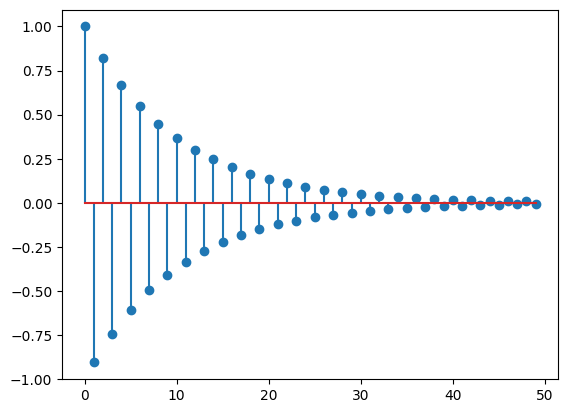

In [259]:
plt.stem(w_model_truth);

2.4627786671909053e-06


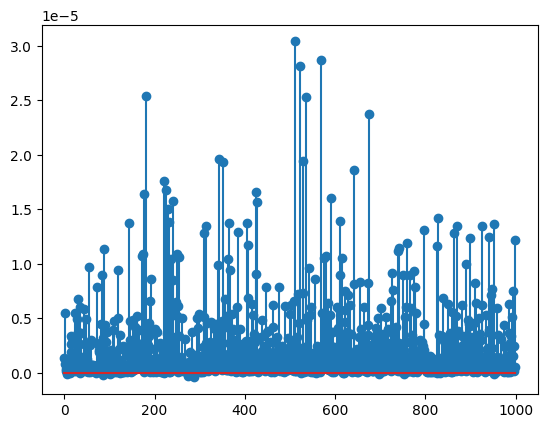

In [260]:
# Check that the gradient grad_i and the numerical gradient of f_i agree
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    model.f_i(ind[0],w)
    grad_error.append((model.f_i( ind[0], w+eps*vec) - model.f_i( ind[0], w))/eps - np.dot(model.grad_i(ind[0],w),vec))
plt.stem(grad_error);
print(np.mean(grad_error))

In [261]:
from scipy.optimize import check_grad

In [262]:
modellog = LogReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellog.f, modellog.grad, np.random.randn(d))

8.463663858079062e-08

In [263]:
modellin = LinReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellin.f, modellin.grad, np.random.randn(d))

1.5380045445783866e-06

### Find a highly accurate solution using LBFGS method

In [264]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.2675458663326288
1.268388071877866e-09


<a id='constant'></a>

## 3. Implementing Stochastic Gradient Descent


### SGD

We recall that an iteration of SGD writes



**for** $t = 1, \ldots, T$
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
w^{t+1} \gets w^t - \gamma^t \nabla f_i(w^t)
$
  
**end for**



Complete the code below. The inputs are
- n_iter: The number of iterations
- indices: an np.array of indices of length n_iter. The indices[t]  is the index of stochastic gradient that will be used on the t-th iteration.
- steps: an np.array of positive floats of length n_iter. The steps[t] is the stepsize used on the kth iteration. Typically decreasing stepsizes are used.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- x_output: The final x vector found by the algorithm or the average  $ \bar{w} = \frac{1}{T-t}\sum_{i=t}^T w^t$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm
- errors: If w_min is not empty, errors is a ndarray containing the sequence of errors || x - w_min || of the algorithm. Otherwise errors should be empty.
*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [265]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False, momentum =0 ,verbose=True, start_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    velocity = np.zeros_like(w0)
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w)
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for t in range(n_iter):
        ### TODO ###
        ####################################
        # Compute the next iterate


        grad = model.grad_i(indices[t], w)
        velocity = momentum * velocity - steps[t] * grad  # Update velocity
        w[:] = w + velocity


        ####################################
        # Compute the average iterate
        # w_average[:]  = ...w_average + .....
        if averaging_on:
            if t >= start_averaging:
              w_average = w_average + (w - w_average) / (t - start_averaging + 1)
            else:
              w_average = w
            w_test = w_average.copy()
        else:
            w_test = w.copy()
        obj = model.f(w_test)
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if t % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % t).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % t).rjust(8),
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()
    return w_output, np.array(objectives), np.array(errors)

In [266]:
##Setup number of iterations
datapasses = 30  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
n_iter = int(datapasses * n)
indices =  np.random.choice(np.arange(n), size=n_iter, replace=True)

### SGD with constant step with replacement

Implement constant stepsizes with steps[t] $= 1/(2L_{\max})$

In [267]:
Lmax = model.L_max_constant(); # Need this constant

In [268]:
##############TODO######################
# Execute SGD with a constant stepsize. Please name the output as
steps_const = np.full(n_iter, 1/(2*Lmax))
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(w_init, model, indices, steps_const, w_min,  n_iter, averaging_on=False, momentum =0 ,verbose=True, start_averaging = 0)
##############END TODO######################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 1.00e+00
    1000 | 3.05e-01 | 3.17e-01
    2000 | 2.96e-01 | 2.48e-01
    3000 | 3.19e-01 | 2.84e-01
    4000 | 2.93e-01 | 2.47e-01
    5000 | 2.86e-01 | 2.02e-01
    6000 | 2.97e-01 | 2.26e-01
    7000 | 3.02e-01 | 2.51e-01
    8000 | 2.94e-01 | 2.48e-01
    9000 | 2.88e-01 | 2.32e-01
   10000 | 2.92e-01 | 2.32e-01
   11000 | 2.95e-01 | 2.22e-01
   12000 | 3.04e-01 | 2.94e-01
   13000 | 3.08e-01 | 2.68e-01
   14000 | 2.95e-01 | 2.27e-01
   15000 | 2.94e-01 | 2.48e-01
   16000 | 3.20e-01 | 3.04e-01
   17000 | 3.00e-01 | 2.10e-01
   18000 | 2.91e-01 | 2.23e-01
   19000 | 3.02e-01 | 2.83e-01
   20000 | 2.90e-01 | 2.19e-01
   21000 | 2.95e-01 | 2.38e-01
   22000 | 3.00e-01 | 2.46e-01
   23000 | 2.98e-01 | 2.44e-01
   24000 | 2.87e-01 | 2.04e-01
   25000 | 2.87e-01 | 1.90e-01
   26000 | 3.10e-01 | 2.46e-01
   27000 | 3.04e-01 | 2.52e-01
   28000 | 3.00e-01 | 2.41e-01
   29000 | 2.96e-01 | 2.44e-01


### SGD with $C/(t+1)$ stepsizes with replacement

Try the following decreasing stepsizes steps[t] $= 1/(2L_{\max}(t+1))$

In [269]:
#############TODO#######################
# Execute SGD with a shrinking stepsize steps[t] = 1/(2L_{\max}(t+1)). Please name the output as
steps_decreasing = np.array([ 1 / (2*Lmax +t) for t in range(n_iter)])
w_sgdsr, obj_sgdsr, err_sgdsr =  sgd(w_init, model, indices, steps_decreasing,w_min,  n_iter, averaging_on=False, momentum =0 ,verbose=True, start_averaging = 0)
##############END TODO######################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 1.00e+00
    1000 | 3.32e-01 | 5.36e-01
    2000 | 3.06e-01 | 4.23e-01
    3000 | 2.98e-01 | 3.64e-01
    4000 | 2.90e-01 | 3.25e-01
    5000 | 2.86e-01 | 2.96e-01
    6000 | 2.84e-01 | 2.78e-01
    7000 | 2.82e-01 | 2.57e-01
    8000 | 2.80e-01 | 2.45e-01
    9000 | 2.79e-01 | 2.35e-01
   10000 | 2.78e-01 | 2.26e-01
   11000 | 2.77e-01 | 2.18e-01
   12000 | 2.77e-01 | 2.11e-01
   13000 | 2.76e-01 | 2.07e-01
   14000 | 2.76e-01 | 2.00e-01
   15000 | 2.75e-01 | 1.96e-01
   16000 | 2.75e-01 | 1.91e-01
   17000 | 2.74e-01 | 1.87e-01
   18000 | 2.74e-01 | 1.83e-01
   19000 | 2.74e-01 | 1.79e-01
   20000 | 2.74e-01 | 1.76e-01
   21000 | 2.73e-01 | 1.73e-01
   22000 | 2.73e-01 | 1.71e-01
   23000 | 2.73e-01 | 1.67e-01
   24000 | 2.73e-01 | 1.65e-01
   25000 | 2.73e-01 | 1.63e-01
   26000 | 2.73e-01 | 1.61e-01
   27000 | 2.73e-01 | 1.60e-01
   28000 | 2.72e-01 | 1.57e-01
   29000 | 2.72e-01 | 1.55e-01


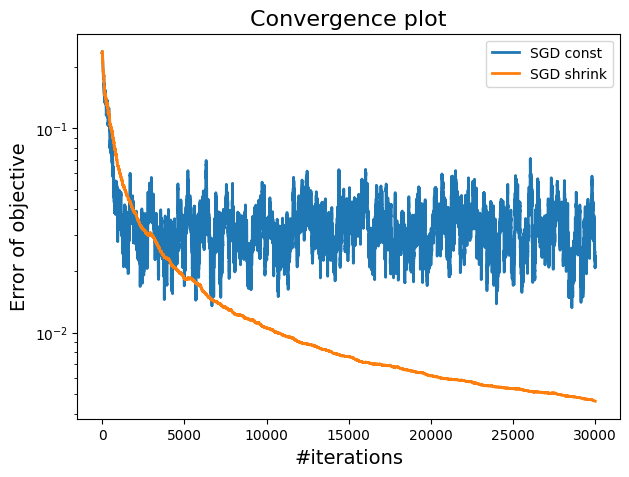

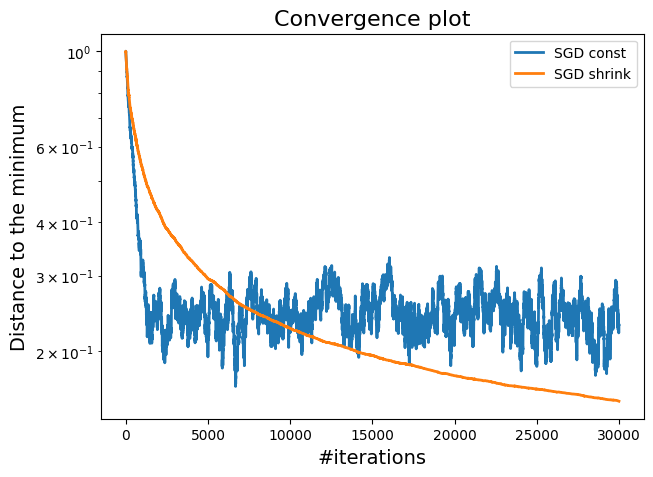

In [295]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD const", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

**Questions**

- Compare the solution you obtain for SGD with constant stepsizes and SGD with shrinking stepsizes.
- Which one is faster in the beginning? Which reaches the "best" solution?
- What happens when is you use sampling without replacement instead? Hint: Do only one datapass, it's annoying to adapt this implementation for more than one datapass when sampling without replacement



**Answer**



*   When implementing Stochastic Gradient Descent (SGD) with a constant step size, initially the model converges faster due to its ability to take relatively large steps consistently. However, as the iterations approach the optimum, the updates begin to oscillate around a region surrounding the optimum. This behavior is attributed to the noise introduced by randomly sampling data points.
*   In contrast, SGD with shrinking step sizes starts with slower convergence. However, as the step size decreases, it reduces the noise, leading to a a more stable convergence to the optimum.

* When sampling without replacement, SGD behaves more similarly to standard Gradient Descent (GD), as each data point contributes equally and is seen the same number of times. It has been observed that SGD with a constant step size benefits more from this method, achieving more stable convergence than SGD with shrinking step sizes.



### SGD with switch to  shrinking stepsizes

In [271]:
mu = model.mu_constant();
Kappa = Lmax/mu;
tstar = 4*int(np.ceil(Kappa));

Test SGD with the following switching stepsizes given in the lecture

$\gamma^t=
\begin{cases}
\displaystyle \tfrac{1}{2L_{\max}} & \mbox{for}\quad t \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \tfrac{2t+1}{(t+1)^2 \mu} &  \mbox{for}\quad t > 4\lceil\mathcal{K} \rceil.
\end{cases}$

In [301]:
#############TODO#######################
# Execute SGD with a switching stepsizes. Please name the output as
# w_sgdsr, obj_sgdss, err_sgdss = sgd(.....?.....)
steps_switching = np.array([ 1/(2*Lmax) if t <= tstar else (2*t+1)/(mu*(t+1)**2) for t in range(n_iter) ])
w_sgdss, obj_sgdss, err_sgdss =  sgd(w_init, model, indices, steps_switching,w_min,  n_iter, averaging_on=False, momentum =0 ,verbose=True, start_averaging = 0)

##############END TODO######################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 1.00e+00
    1000 | 3.05e-01 | 3.17e-01
    2000 | 2.91e-01 | 2.28e-01
    3000 | 2.98e-01 | 2.17e-01
    4000 | 2.77e-01 | 1.54e-01
    5000 | 2.75e-01 | 1.33e-01
    6000 | 2.76e-01 | 1.28e-01
    7000 | 2.75e-01 | 1.17e-01
    8000 | 2.73e-01 | 1.14e-01
    9000 | 2.72e-01 | 1.04e-01
   10000 | 2.72e-01 | 9.61e-02
   11000 | 2.71e-01 | 8.75e-02
   12000 | 2.71e-01 | 9.40e-02
   13000 | 2.73e-01 | 1.02e-01
   14000 | 2.71e-01 | 8.69e-02
   15000 | 2.70e-01 | 7.90e-02
   16000 | 2.71e-01 | 8.93e-02
   17000 | 2.72e-01 | 8.82e-02
   18000 | 2.71e-01 | 8.35e-02
   19000 | 2.71e-01 | 8.47e-02
   20000 | 2.70e-01 | 7.37e-02
   21000 | 2.71e-01 | 7.70e-02
   22000 | 2.70e-01 | 6.94e-02
   23000 | 2.69e-01 | 6.47e-02
   24000 | 2.69e-01 | 6.22e-02
   25000 | 2.70e-01 | 6.59e-02
   26000 | 2.69e-01 | 5.81e-02
   27000 | 2.70e-01 | 6.15e-02
   28000 | 2.69e-01 | 5.70e-02
   29000 | 2.69e-01 | 5.60e-02


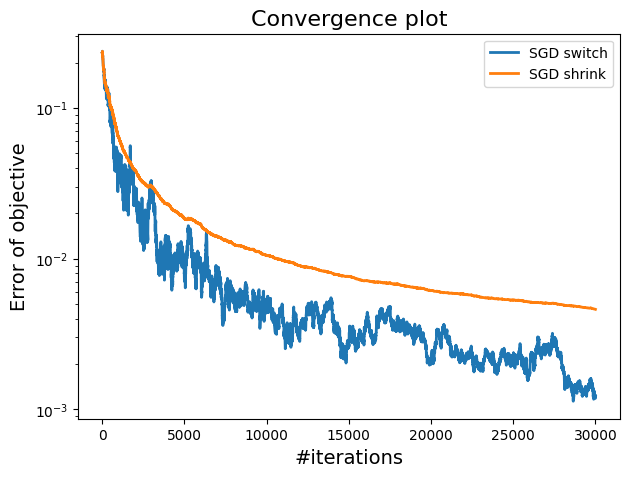

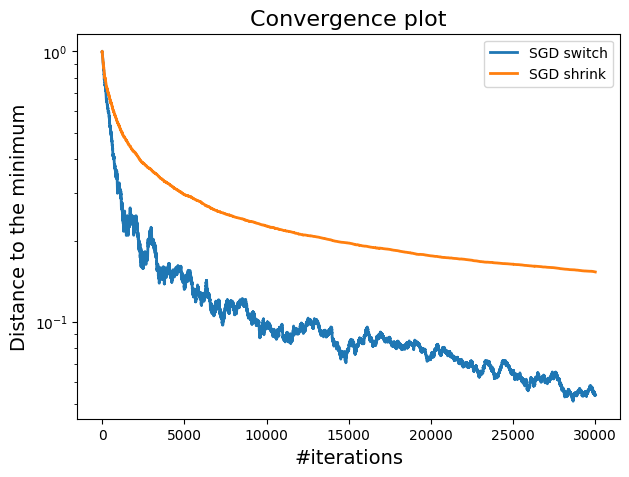

In [302]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## 5. Compare with averaging step

- Implement the average iterate output  
- Compare the solution you obtain for SGD with shrinking stepsizes and SGD with averaging.
- What happens if you start averaging only the last n iterates? When is averaging useful?


**Observations**


In SGD with averaging,  the weights are averaged over time to smooth out fluctuations and help with convergence. Usually, it's useful in the later stages of training when the algorithm has already seen enough examples to reduce noise. In this experiment however, SDG with shrinking step sizes and averaging fared worse than SGD with averaging alone. It is also observed that starting the averaging process later in the iteration reduced the discrepancy in the results. We suspect that the data could have high variance leading to the averaging leading to less effective updates.



In [305]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# w_sgdar, obj_sgdar, err_sgdar = sgd( .... )
# HINT: you can use the same stepsizes as decreasing and average just the last n_iter/4 steps
steps_shrink_w_avg = np.array([ 1/(2*Lmax +t) for t in range(n_iter)])
w_sgdar, obj_sgdar, err_sgdar =  sgd(w_init, model, indices, steps_shrink_w_avg ,w_min,  n_iter, averaging_on=True, momentum =0 ,verbose=True, start_averaging = int(3 * n_iter // 4) )
###############END TODO#####################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 1.00e+00
    1000 | 3.32e-01 | 5.36e-01
    2000 | 3.06e-01 | 4.23e-01
    3000 | 2.98e-01 | 3.64e-01
    4000 | 2.90e-01 | 3.25e-01
    5000 | 2.86e-01 | 2.96e-01
    6000 | 2.84e-01 | 2.78e-01
    7000 | 2.82e-01 | 2.57e-01
    8000 | 2.80e-01 | 2.45e-01
    9000 | 2.79e-01 | 2.35e-01
   10000 | 2.78e-01 | 2.26e-01
   11000 | 2.77e-01 | 2.18e-01
   12000 | 2.77e-01 | 2.11e-01
   13000 | 2.76e-01 | 2.07e-01
   14000 | 2.76e-01 | 2.00e-01
   15000 | 2.75e-01 | 1.96e-01
   16000 | 2.75e-01 | 1.91e-01
   17000 | 2.74e-01 | 1.87e-01
   18000 | 2.74e-01 | 1.83e-01
   19000 | 2.74e-01 | 1.79e-01
   20000 | 2.74e-01 | 1.76e-01
   21000 | 2.73e-01 | 1.73e-01
   22000 | 2.73e-01 | 1.71e-01
   23000 | 2.73e-01 | 1.68e-01
   24000 | 2.73e-01 | 1.67e-01
   25000 | 2.73e-01 | 1.66e-01
   26000 | 2.73e-01 | 1.65e-01
   27000 | 2.73e-01 | 1.64e-01
   28000 | 2.73e-01 | 1.63e-01
   29000 | 2.73e-01 | 1.62e-01


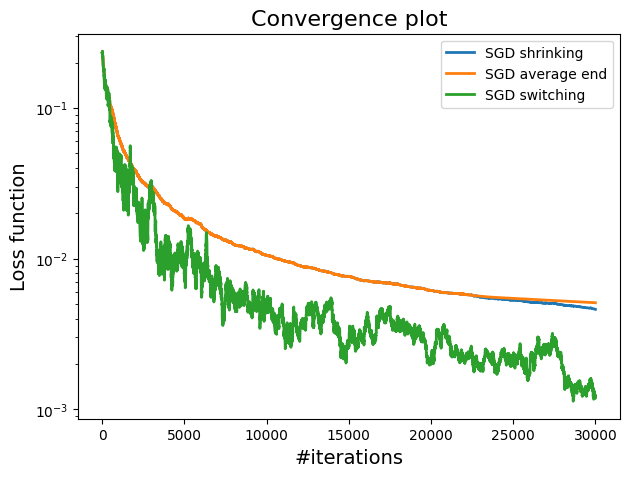

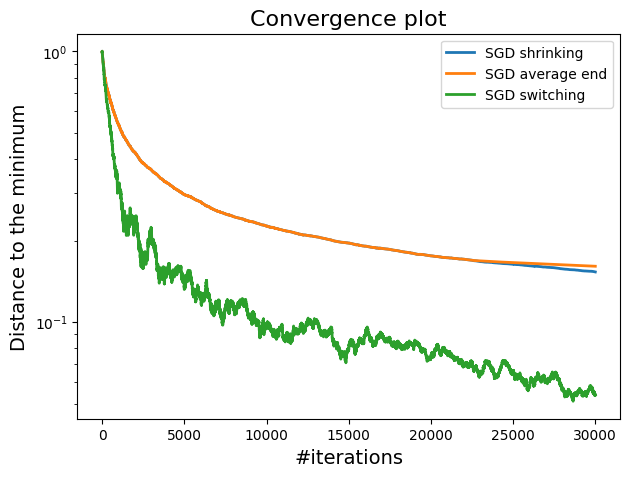

In [307]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrinking", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switching", lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdsr , label="SGD shrinking", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.semilogy(err_sgdss , label="SGD switching", lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare with SGD with momentum (SGDm)

- Implement the momentum variant in SGD
- Compare with averaging and decreasing stepsizes with late start
- For what momentum parameters does SGDm work well?
- Combining all the tricks/variants seen so far, what is the best variant of SGD for this problem?

**Answer**


*   SGD with momentum incorporates a momentum term that amplifies the gradient in directions that consistently exhibit the same sign and dampens the gradient in directions with reverse signs. If the current gradient aligns with the previous step's direction, the update moves further in that direction; if it is in the opposite direction, the update is smaller.
*   Experiments revealed that SGD with momentum outperformed all other SGD variants in this study. A momentum parameter of 0.7 yielded the best results, producing the lowest overall error.





In [308]:
#############TODO#######################
# Execute SGD with momentum. Please name the output as
# w_sgdm, obj_sgdm, err_sgdm = sgd( .... )
# HINT: you can use the same stepsizes as decreasing and average just the last n_iter/4 steps
w_sgdm, obj_sgdm, err_sgdm = sgd(w_init, model, indices, steps_shrink_w_avg ,w_min,  n_iter, averaging_on=False, momentum =0.7 ,verbose=True, start_averaging = int(3 * n_iter // 4) )
###############END TODO#####################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 1.00e+00
    1000 | 2.91e-01 | 2.45e-01
    2000 | 2.79e-01 | 1.73e-01
    3000 | 2.83e-01 | 1.56e-01
    4000 | 2.72e-01 | 1.11e-01
    5000 | 2.71e-01 | 9.94e-02
    6000 | 2.73e-01 | 9.74e-02
    7000 | 2.71e-01 | 8.18e-02
    8000 | 2.70e-01 | 7.77e-02
    9000 | 2.70e-01 | 7.45e-02
   10000 | 2.70e-01 | 7.07e-02
   11000 | 2.69e-01 | 6.38e-02
   12000 | 2.69e-01 | 6.68e-02
   13000 | 2.70e-01 | 7.12e-02
   14000 | 2.70e-01 | 6.66e-02
   15000 | 2.69e-01 | 6.08e-02
   16000 | 2.69e-01 | 6.19e-02
   17000 | 2.69e-01 | 6.26e-02
   18000 | 2.70e-01 | 6.13e-02
   19000 | 2.69e-01 | 5.97e-02
   20000 | 2.69e-01 | 5.32e-02
   21000 | 2.69e-01 | 5.49e-02
   22000 | 2.69e-01 | 5.23e-02
   23000 | 2.69e-01 | 4.85e-02
   24000 | 2.69e-01 | 4.71e-02
   25000 | 2.69e-01 | 4.83e-02
   26000 | 2.68e-01 | 4.37e-02
   27000 | 2.69e-01 | 4.56e-02
   28000 | 2.69e-01 | 4.31e-02
   29000 | 2.68e-01 | 4.22e-02


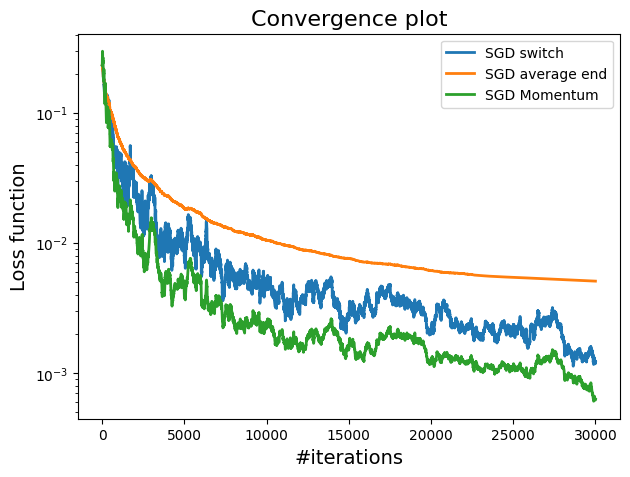

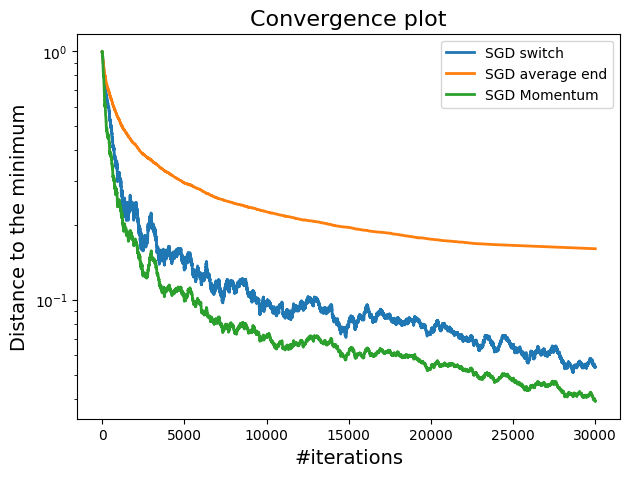

In [310]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="SGD Momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.semilogy(err_sgdm , label="SGD Momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare with gradient descent

- Complete the code of gradient descent (GD) below
- How much more is the computational cost of a step of gradient descent with respect to the computational cost of a SGD step?  How many steps of gradient descent should you take so that the total computational complexity is equivalent to datapasses * n steps of SGD ?
- Compare GD with SGD, where on the $x$-axis of the plot you the total computational effort spent
- What happens if you increase the number of datapasses?

**Answer**


*  Regarding computational complexity, each step of GD involves calculating the gradient of the loss function with respect to all
𝑛 samples in the dataset, resulting in a total cost for 𝑇 steps of
𝑇
⋅
(𝑂
(
𝑛
))

*   In contrast, each step of SGD involves computing the gradient with respect to a single sample, yielding a cost of
𝑂(1) per step.

* To match the computational complexity of
(datapasses⋅𝑛) steps of SGD, an equivalent number of
(#datapasses) steps are required for GD.



In [279]:
def gd(w0, model, step, w_min =[], n_iter=100, verbose=True):
    """Gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w)
    objectives.append(obj)
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter ):
        ##### TODO ######################
        ##### Compute gradient step update
        grad = model.grad(w)
        w[:] = w - step * grad  # Update velocity

        ##### END TODO ##################
        obj = model.f(w)
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [280]:
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w_init, model, step, w_min, datapasses)
print(obj_gd)

Lauching GD solver...
   it    |   obj    |   err   
       0 | 4.24e-01 | 8.58e-01
       1 | 3.83e-01 | 7.43e-01
       2 | 3.53e-01 | 6.46e-01
       3 | 3.32e-01 | 5.62e-01
       4 | 3.16e-01 | 4.90e-01
       5 | 3.04e-01 | 4.28e-01
       6 | 2.95e-01 | 3.74e-01
       7 | 2.89e-01 | 3.27e-01
       8 | 2.84e-01 | 2.86e-01
       9 | 2.80e-01 | 2.51e-01
      10 | 2.77e-01 | 2.20e-01
      11 | 2.75e-01 | 1.93e-01
      12 | 2.73e-01 | 1.69e-01
      13 | 2.72e-01 | 1.49e-01
      14 | 2.71e-01 | 1.31e-01
      15 | 2.70e-01 | 1.15e-01
      16 | 2.69e-01 | 1.01e-01
      17 | 2.69e-01 | 8.92e-02
      18 | 2.69e-01 | 7.86e-02
      19 | 2.68e-01 | 6.93e-02
      20 | 2.68e-01 | 6.11e-02
      21 | 2.68e-01 | 5.40e-02
      22 | 2.68e-01 | 4.76e-02
      23 | 2.68e-01 | 4.21e-02
      24 | 2.68e-01 | 3.72e-02
      25 | 2.68e-01 | 3.29e-02
      26 | 2.68e-01 | 2.91e-02
      27 | 2.68e-01 | 2.57e-02
      28 | 2.68e-01 | 2.28e-02
      29 | 2.68e-01 | 2.02e-02
[0.5        0.424

In [281]:
complexityofGD = n * np.arange(0, datapasses + 1)
complexityofSGD =  np.arange(0, datapasses + 1)
print(complexityofGD)
print(complexityofSGD)

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


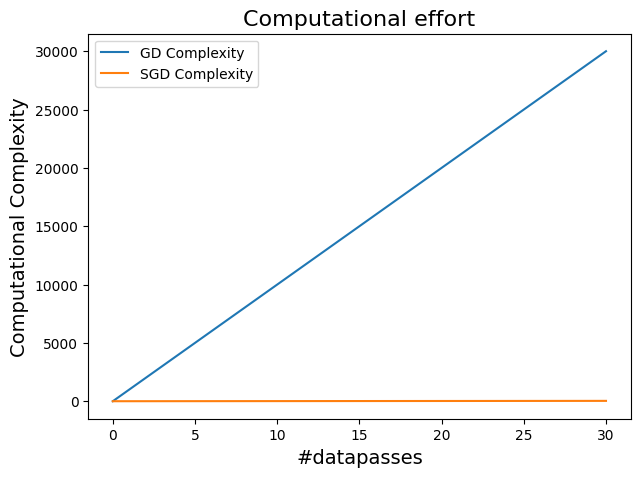

In [282]:
plt.figure(figsize=(7, 5))
plt.plot(complexityofGD, label="GD Complexity")
plt.plot(complexityofSGD, label="SGD Complexity")
plt.title("Computational effort", fontsize=16)
plt.xlabel("#datapasses", fontsize=14)
plt.ylabel("Computational Complexity", fontsize=14)
plt.legend()

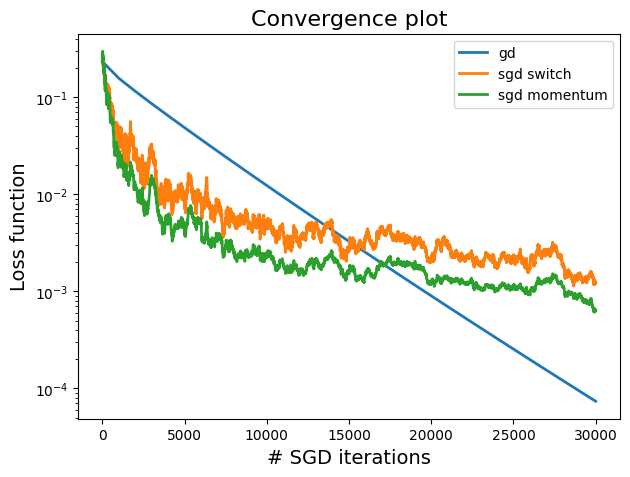

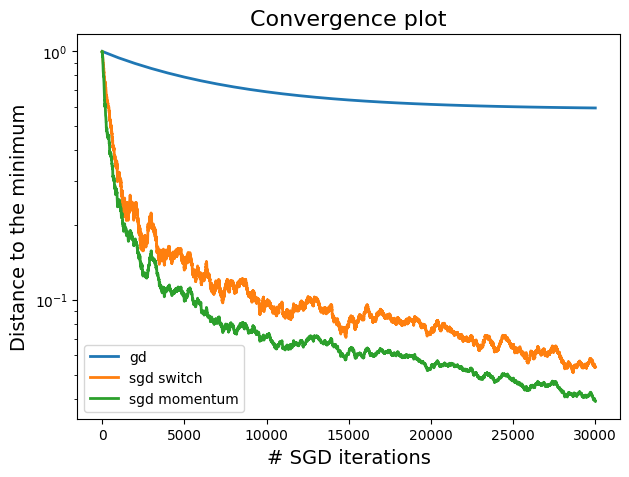

In [311]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, obj_gd - obj_min, label="gd", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="sgd switch", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="sgd momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimum on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, err_gd, label="gd", lw=2)
plt.semilogy(err_sgdss , label="sgd switch", lw=2)
plt.semilogy(err_sgdm , label="sgd momentum", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## BONUS: SGD without replacement

-Execute SGD where the indices of the data points are sampled *without* replacement over each datapass

In [284]:
#############TODO#######################
# Execute SGD with averaging on and shrinking stepsize. Please name the output as
# w_sgdsw, obj_sgdsw, err_sgdsw = sgd(....)
# HINT: You should use numpy.matlib's repmat function to
#import numpy.matlib
# With replacement

indices_wr = np.matlib.repmat(np.random.permutation(n), 1, datapasses)[0, :n_iter]

w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w_init, model, indices_wr, steps_switching ,w_min,  n_iter, averaging_on=True, momentum =0 ,verbose=True, start_averaging = int(3 * n_iter // 4) )

###############END TODO#####################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 9.96e-01
    1000 | 3.04e-01 | 2.56e-01
    2000 | 2.92e-01 | 1.80e-01
    3000 | 2.82e-01 | 1.31e-01
    4000 | 2.76e-01 | 1.02e-01
    5000 | 2.74e-01 | 8.35e-02
    6000 | 2.72e-01 | 7.01e-02
    7000 | 2.71e-01 | 6.03e-02
    8000 | 2.70e-01 | 5.28e-02
    9000 | 2.69e-01 | 4.69e-02
   10000 | 2.69e-01 | 4.22e-02
   11000 | 2.69e-01 | 3.83e-02
   12000 | 2.69e-01 | 3.51e-02
   13000 | 2.68e-01 | 3.23e-02
   14000 | 2.68e-01 | 3.00e-02
   15000 | 2.68e-01 | 2.80e-02
   16000 | 2.68e-01 | 2.62e-02
   17000 | 2.68e-01 | 2.46e-02
   18000 | 2.68e-01 | 2.32e-02
   19000 | 2.68e-01 | 2.20e-02
   20000 | 2.68e-01 | 2.09e-02
   21000 | 2.68e-01 | 1.99e-02
   22000 | 2.68e-01 | 1.90e-02
   23000 | 2.68e-01 | 1.03e-02
   24000 | 2.68e-01 | 6.83e-03
   25000 | 2.68e-01 | 6.32e-03
   26000 | 2.68e-01 | 6.08e-03
   27000 | 2.68e-01 | 5.92e-03
   28000 | 2.68e-01 | 5.78e-03
   29000 | 2.68e-01 | 5.67e-03


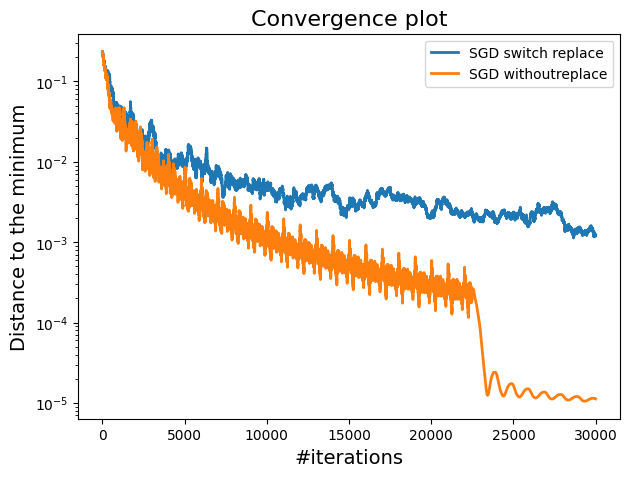

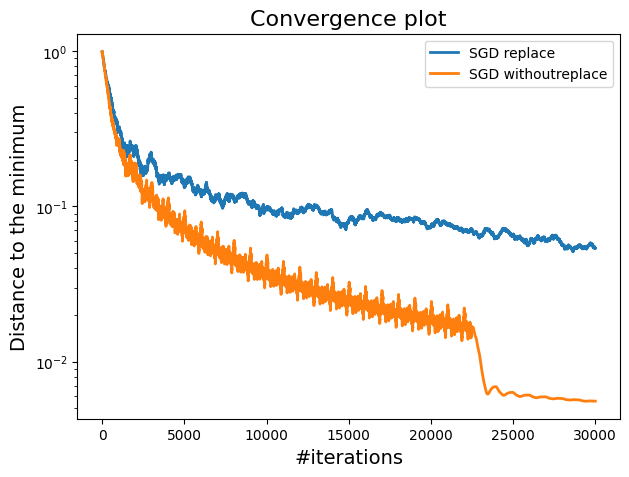

In [285]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdss - obj_min, label="SGD switch replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdss , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

In [286]:
w_sgdawr, obj_sgdawr, err_sgdawr = sgd(w_init, model, indices_wr, steps_shrink_w_avg ,w_min,  n_iter, averaging_on=True, momentum =0 ,verbose=True, start_averaging = int(3 * n_iter // 4) )

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 9.96e-01
    1000 | 3.16e-01 | 4.84e-01
    2000 | 2.97e-01 | 3.82e-01
    3000 | 2.89e-01 | 3.30e-01
    4000 | 2.85e-01 | 2.98e-01
    5000 | 2.82e-01 | 2.74e-01
    6000 | 2.81e-01 | 2.57e-01
    7000 | 2.79e-01 | 2.42e-01
    8000 | 2.78e-01 | 2.31e-01
    9000 | 2.77e-01 | 2.21e-01
   10000 | 2.76e-01 | 2.13e-01
   11000 | 2.76e-01 | 2.05e-01
   12000 | 2.75e-01 | 1.99e-01
   13000 | 2.75e-01 | 1.93e-01
   14000 | 2.74e-01 | 1.88e-01
   15000 | 2.74e-01 | 1.83e-01
   16000 | 2.74e-01 | 1.79e-01
   17000 | 2.73e-01 | 1.75e-01
   18000 | 2.73e-01 | 1.71e-01
   19000 | 2.73e-01 | 1.68e-01
   20000 | 2.73e-01 | 1.65e-01
   21000 | 2.73e-01 | 1.62e-01
   22000 | 2.72e-01 | 1.59e-01
   23000 | 2.72e-01 | 1.57e-01
   24000 | 2.72e-01 | 1.56e-01
   25000 | 2.72e-01 | 1.54e-01
   26000 | 2.72e-01 | 1.53e-01
   27000 | 2.72e-01 | 1.52e-01
   28000 | 2.72e-01 | 1.51e-01
   29000 | 2.72e-01 | 1.50e-01


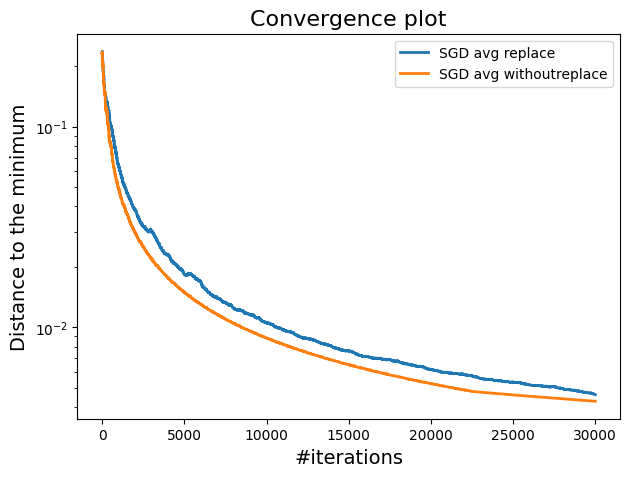

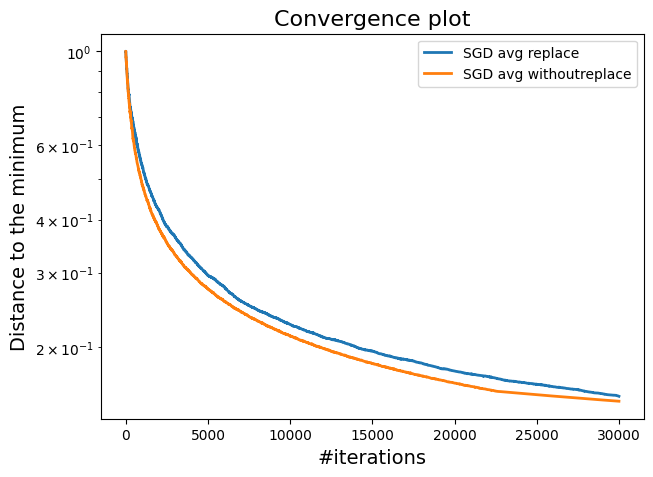

In [287]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdar - obj_min, label="SGD avg replace", lw=2)
plt.plot(obj_sgdawr - obj_min, label="SGD avg withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdar , label="SGD avg replace", lw=2)
plt.plot(err_sgdawr , label="SGD avg withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

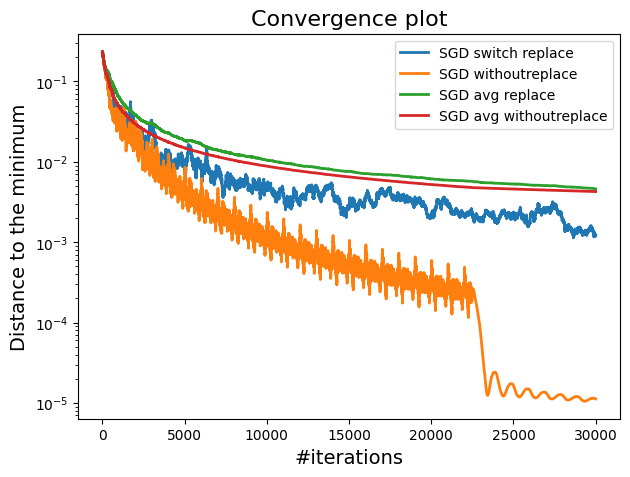

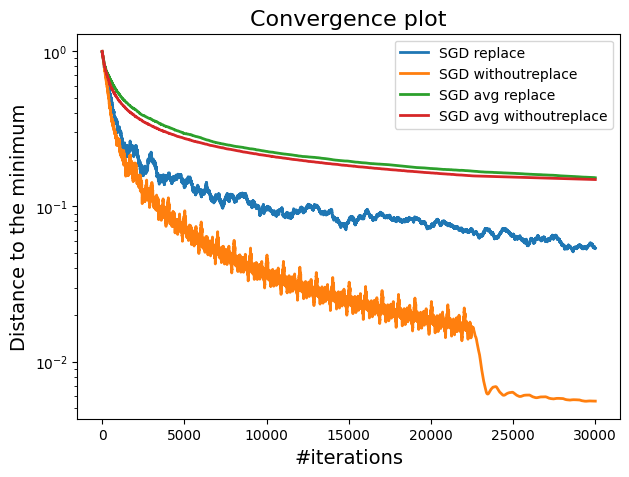

In [288]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdss - obj_min, label="SGD switch replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.plot(obj_sgdar - obj_min, label="SGD avg replace", lw=2)
plt.plot(obj_sgdawr - obj_min, label="SGD avg withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdss , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.plot(err_sgdar , label="SGD avg replace", lw=2)
plt.plot(err_sgdawr , label="SGD avg withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare SGD and GD in terms of test error. That is, use w_model_truth to compare¶

In [290]:
datapasses = 30;
n_iters = int(datapasses * n)


## SGD without replacement, decreasing stepsize, averaging at end
#############TODO#######################
w_sgdar, obj_sgdar, err_sgdar    =  sgd(w_init, model, indices_wr, steps_shrink_w_avg ,w_model_truth,  n_iter, averaging_on=True, momentum =0 ,verbose=True, start_averaging = int(3 * n_iter // 4) )
###############END TODO#####################


## SGD without replacement, decreasing stepsize, no averaging
#############TODO#######################
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w_init, model, indices_wr, steps_decreasing ,w_model_truth,  n_iter, averaging_on=False, momentum =0 ,verbose=True, start_averaging = int(3 * n_iter // 4) )
###############END TODO#####################

## GD
#############TODO#######################
w_gd, obj_gd, err_gd = gd(w_init, model, step, w_model_truth, datapasses)
###############END TODO#####################

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 5.03e-01 | 9.98e-01
    1000 | 3.16e-01 | 7.85e-01
    2000 | 2.97e-01 | 7.42e-01
    3000 | 2.89e-01 | 7.21e-01
    4000 | 2.85e-01 | 7.07e-01
    5000 | 2.82e-01 | 6.97e-01
    6000 | 2.81e-01 | 6.90e-01
    7000 | 2.79e-01 | 6.84e-01
    8000 | 2.78e-01 | 6.79e-01
    9000 | 2.77e-01 | 6.75e-01
   10000 | 2.76e-01 | 6.72e-01
   11000 | 2.76e-01 | 6.69e-01
   12000 | 2.75e-01 | 6.66e-01
   13000 | 2.75e-01 | 6.63e-01
   14000 | 2.74e-01 | 6.61e-01
   15000 | 2.74e-01 | 6.59e-01
   16000 | 2.74e-01 | 6.57e-01
   17000 | 2.73e-01 | 6.56e-01
   18000 | 2.73e-01 | 6.54e-01
   19000 | 2.73e-01 | 6.53e-01
   20000 | 2.73e-01 | 6.52e-01
   21000 | 2.73e-01 | 6.50e-01
   22000 | 2.72e-01 | 6.49e-01
   23000 | 2.72e-01 | 6.48e-01
   24000 | 2.72e-01 | 6.48e-01
   25000 | 2.72e-01 | 6.47e-01
   26000 | 2.72e-01 | 6.47e-01
   27000 | 2.72e-01 | 6.46e-01
   28000 | 2.72e-01 | 6.46e-01
   29000 | 2.72e-01 | 6.46e-01
Lauching SGD sol

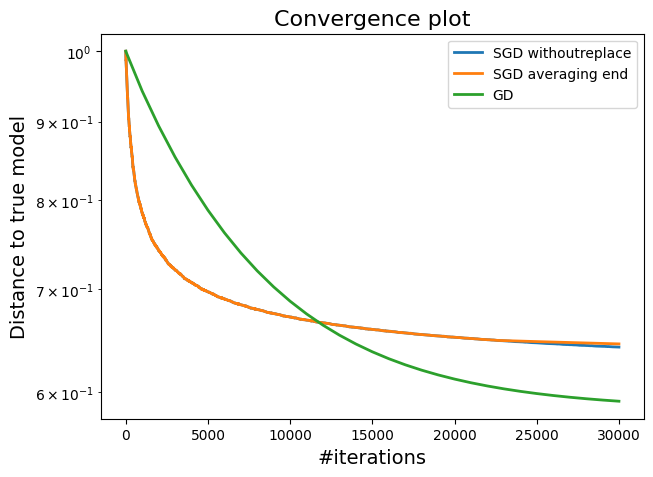

In [291]:
complexityofGD = n * np.arange(0, datapasses + 1)

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(err_sgdar , label="SGD averaging end", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## THE END!